# **Import Libraries**

In [ ]:
# Enable TensorFlow Debug Mode
import tensorflow as tf
tf.data.experimental.enable_debug_mode()

# Essential Libraries
import numpy as np
import time
import matplotlib.pyplot as plt

# TensorFlow and Keras Modules
from tensorflow import keras
from tensorflow.keras import layers, models, regularizers, Input, activations, optimizers,  backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.activations import swish, gelu
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.backend import sigmoid

# Dataset Handling
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

### Task 1: Load the CIFAR-100 data set and select a subset to work with. The data set is already split into training and test sets.  

In [ ]:
### Step 1: Load and Extract a Subset from CIFAR-100

# Load CIFAR-100 dataset (already split into train and test sets)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar100.load_data()

# Manually define CIFAR-100 class labels for reference
cifar100_labels = [
    'apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy',
    'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock',
    'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish',
    'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion',
    'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange',
    'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine',
    'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk',
    'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table',
    'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe',
    'whale', 'willow_tree', 'wolf', 'woman', 'worm'
]

# Select 10 specific classes from CIFAR-100
selected_classes = ['apple', 'bus', 'dolphin', 'motorcycle', 'rabbit', 'skyscraper', 'snake', 'tiger', 'train', 'whale']
selected_class_indices = [cifar100_labels.index(cls) for cls in selected_classes]

# Extract images belonging to the selected classes from the dataset
selected_train_indices = np.isin(y_train, selected_class_indices).flatten()
selected_test_indices = np.isin(y_test, selected_class_indices).flatten()

x_train_selected, y_train_selected = x_train[selected_train_indices], y_train[selected_train_indices]
x_test_selected, y_test_selected = x_test[selected_test_indices], y_test[selected_test_indices]

# Convert original class labels to new indices (0 to 9) for the selected classes
class_mapping = {old_label: new_label for new_label, old_label in enumerate(selected_class_indices)}
y_train_selected = np.vectorize(class_mapping.get)(y_train_selected)
y_test_selected = np.vectorize(class_mapping.get)(y_test_selected)

# Reduce dataset size (e.g., 300 images per class for training, 50 per class for testing)
num_images_per_class_train = 300
num_images_per_class_test = 50

x_train_final, y_train_final = [], []
x_test_final, y_test_final = [], []

# Select the first 'num_images_per_class' samples for each class
for cls in range(len(selected_classes)):
    cls_indices_train = np.where(y_train_selected == cls)[0][:num_images_per_class_train]
    cls_indices_test = np.where(y_test_selected == cls)[0][:num_images_per_class_test]

    x_train_final.append(x_train_selected[cls_indices_train])
    y_train_final.append(y_train_selected[cls_indices_train])

    x_test_final.append(x_test_selected[cls_indices_test])
    y_test_final.append(y_test_selected[cls_indices_test])

# Convert lists to numpy arrays
x_train_final = np.concatenate(x_train_final, axis=0)
y_train_final = np.concatenate(y_train_final, axis=0)
x_test_final = np.concatenate(x_test_final, axis=0)
y_test_final = np.concatenate(y_test_final, axis=0)

# Normalize image pixel values to the range [0,1]
x_train_final = x_train_final.astype('float32') / 255.0
x_test_final = x_test_final.astype('float32') / 255.0

# One-hot encode labels for training and testing sets
y_train_final = to_categorical(y_train_final, num_classes=len(selected_classes))
y_test_final = to_categorical(y_test_final, num_classes=len(selected_classes))

# Verify final dataset shape
print(f"Train Data Shape: {x_train_final.shape}, Train Labels: {y_train_final.shape}")
print(f"Test Data Shape: {x_test_final.shape}, Test Labels: {y_test_final.shape}")

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Train Data Shape: (3000, 32, 32, 3), Train Labels: (3000, 10)
Test Data Shape: (500, 32, 32, 3), Test Labels: (500, 10)


### Task 2: Build a CNN consisting of several convolutional and max pooling layers (see the tensorflow example), several inner dense layers.

In [ ]:
# Define the CNN model using an explicit Input layer
model = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer for 32x32 RGB images

    # First convolutional block
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # First convolutional layer with 32 filters
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Second convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions
    layers.Dropout(0.25),  # Dropout to prevent overfitting

    # Second convolutional block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Third convolutional layer with 64 filters
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Fourth convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Dropout(0.25),  # Dropout to prevent overfitting

    # Third convolutional block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Fifth convolutional layer with 128 filters
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Sixth convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling layer
    layers.Dropout(0.25),  # Dropout to reduce overfitting

    # Fully connected (dense) layers
    layers.Flatten(),  # Flatten feature maps into a single vector
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 neurons
    layers.Dropout(0.5),  # Dropout to further reduce overfitting
    layers.Dense(10, activation='softmax')  # Output layer with 10 neurons (one per class) and softmax activation
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print the model summary to visualize the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 8, 8, 128)           │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,341,226 (5.12 MB)

 Trainable params: 1,341,226 (5.12 MB)

 Non-trainable params: 0 (0.00 B)

### Task 3: Train your CNN on the training set (extracted in task 1)

In [ ]:
# Compile the model
model.compile(optimizer='adam',  # Using Adam optimizer for adaptive learning rate adjustment
              loss='categorical_crossentropy',  # Loss function for multi-class classification
              metrics=['accuracy'])  # Tracking accuracy as the evaluation metric

# Train the model on the training dataset
history = model.fit(x_train_final, y_train_final,  # Training data and labels
                    epochs=25,  # Number of training iterations over the dataset
                    batch_size=64,  # Number of samples per gradient update
                    validation_data=(x_test_final, y_test_final))  # Evaluate performance on the test set

Epoch 1/25
 2/47 ━━━━━━━━━━━━━━━━━━━━ 18s 411ms/step - accuracy: 0.0664 - loss: 2.3085

KeyboardInterrupt: 

### Task 4: Evaluate your trained model using the test data set. What is the accuracy of your model?

In [ ]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test_final, y_test_final)

# Print accuracy
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - accuracy: 0.7417 - loss: 0.9077
Test Accuracy: 71.20%


#### Task 4.1: Plotting training and validation accuracy

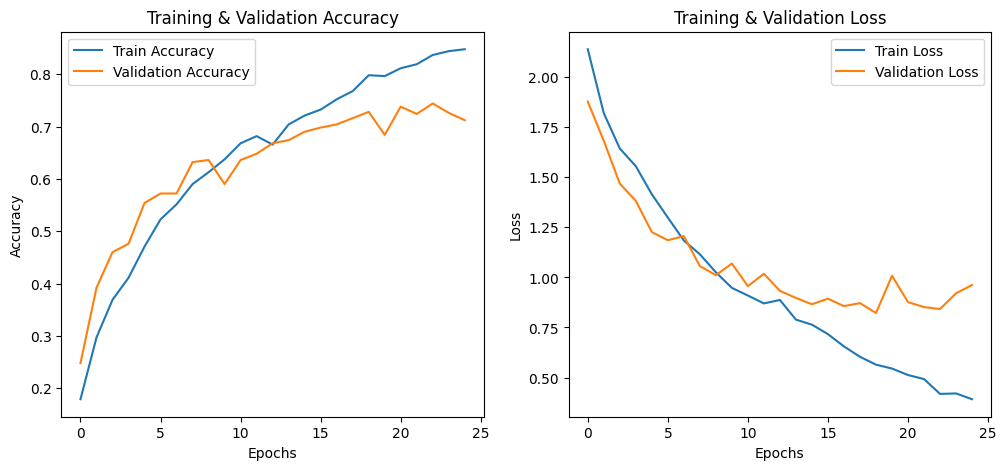

In [ ]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))  # Set figure size for better visibility

# Subplot 1: Training and validation accuracy
plt.subplot(1, 2, 1)  # Create first subplot (1 row, 2 columns, position 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')  # Plot training accuracy
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')  # Plot validation accuracy
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Accuracy')  # Label for y-axis
plt.legend()  # Display legend
plt.title('Training & Validation Accuracy')  # Title of the plot

# Subplot 2: Training and validation loss
plt.subplot(1, 2, 2)  # Create second subplot (1 row, 2 columns, position 2)
plt.plot(history.history['loss'], label='Train Loss')  # Plot training loss
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot validation loss
plt.xlabel('Epochs')  # Label for x-axis
plt.ylabel('Loss')  # Label for y-axis
plt.legend()  # Display legend
plt.title('Training & Validation Loss')  # Title of the plot

# Display the plots
plt.show()

### Task 4 Conclusion:

<font color = green>The CNN model trained on a subset of CIFAR-100 achieved a test accuracy of 71 20%, demonstrating its ability to generalize well to unseen data. This result indicates that the model is effectively learning distinguishing features from the selected 10 classes despite the limited training data. The chosen architecture, consisting of multiple convolutional layers, dropout regularization, and fully connected layers, played a key role in achieving this performance.

### Task 5: Do the following experiments to improve accuracy:

#### Task 5.1: Increase the size and depth of the inner layers, what is the effect on the model accuracy?

##### Task 5.1.1: Defining a deep and optimized CNN model

In [ ]:
# Define a deeper and optimized CNN model
model_v2 = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Explicit Input layer specifying the input shape

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # First convolution layer with 64 filters
    layers.BatchNormalization(),  # Normalize activations for stable training
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Second convolution layer
    layers.BatchNormalization(),  # Normalize activations
    layers.MaxPooling2D((2, 2)),  # Reduce spatial dimensions (downsampling)
    layers.Dropout(0.2),  # Prevent overfitting by randomly dropping connections

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # First convolution layer with 128 filters
    layers.BatchNormalization(),  # Normalize activations
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Second convolution layer
    layers.BatchNormalization(),  # Normalize activations
    layers.MaxPooling2D((2, 2)),  # Downsampling
    layers.Dropout(0.3),  # Higher dropout rate to further prevent overfitting

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # First convolution layer with 256 filters
    layers.BatchNormalization(),  # Normalize activations
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Second convolution layer
    layers.BatchNormalization(),  # Normalize activations
    layers.MaxPooling2D((2, 2)),  # Downsampling
    layers.Dropout(0.4),  # Increase dropout rate for more regularization

    # Fourth Convolutional Block
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),  # First convolution layer with 512 filters
    layers.BatchNormalization(),  # Normalize activations
    layers.Conv2D(512, (3, 3), activation='relu', padding='same'),  # Second convolution layer
    layers.BatchNormalization(),  # Normalize activations
    layers.MaxPooling2D((2, 2)),  # Downsampling
    layers.Dropout(0.4),  # Maintain high dropout to reduce overfitting

    # Fully Connected Layers
    layers.Flatten(),  # Flatten the feature maps into a 1D vector for classification
    layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # First dense layer with L2 regularization
    layers.BatchNormalization(),  # Normalize activations
    layers.Dropout(0.4),  # Dropout for regularization

    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),  # Second dense layer with L2 regularization
    layers.BatchNormalization(),  # Normalize activations
    layers.Dropout(0.3),  # Dropout for regularization

    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

##### Task 5.1.2: Model Compilation

In [ ]:
# Compile the model with a lower learning rate
model_v2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])

# Print the model summary
model_v2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 64)          │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 16, 16, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 16, 16, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 8, 8, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 8, 8, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 8, 8, 256)           │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 8, 8, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 4, 4, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 5,879,114 (22.43 MB)

 Trainable params: 5,873,738 (22.41 MB)

 Non-trainable params: 5,376 (21.00 KB)

##### Task 5.1.3: Training and evaluating the model

In [ ]:
history_v2 = model_v2.fit(x_train_final, y_train_final,
                          epochs=25,
                          batch_size=64,
                          validation_data=(x_test_final, y_test_final))

# Evaluate the optimized model
test_loss_v2, test_accuracy_v2 = model_v2.evaluate(x_test_final, y_test_final)

print(f"Test Accuracy after optimizations: {test_accuracy_v2 * 100:.2f}%")

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 34s 354ms/step - accuracy: 0.2107 - loss: 3.8616 - val_accuracy: 0.1000 - val_loss: 4.1013
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.4387 - loss: 2.8646 - val_accuracy: 0.1020 - val_loss: 5.4558
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.4989 - loss: 2.6538 - val_accuracy: 0.1180 - val_loss: 6.5186
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5383 - loss: 2.4526 - val_accuracy: 0.1420 - val_loss: 5.6900
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5751 - loss: 2.3039 - val_accuracy: 0.1440 - val_loss: 6.0478
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.5822 - loss: 2.2699 - val_accuracy: 0.1240 - val_loss: 5.7831
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.6141 - loss: 2.1741 - val_accuracy: 0.2340 - val_loss: 4.4581
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.6453 - loss: 2.0428 - val_accuracy: 0.3000 -

##### Task 5.1.4: Plotting the training and validation accuracy

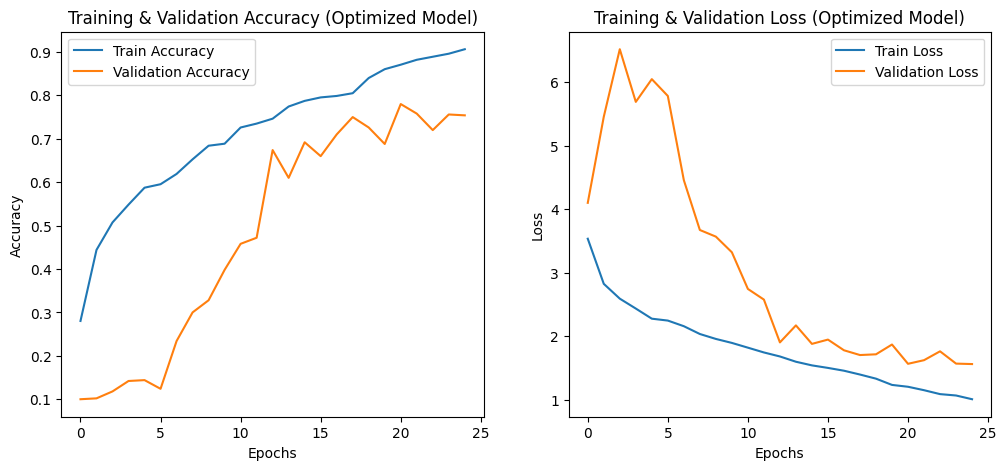

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_v2.history['accuracy'], label='Train Accuracy')
plt.plot(history_v2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy (Optimized Model)')

# Plot the training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history_v2.history['loss'], label='Train Loss')
plt.plot(history_v2.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss (Optimized Model)')

plt.show()

#### Task 5.1. Conlusion:

<font color = green>The optimized CNN model achieved a test accuracy of 75.40%, marking a 4.2% improvement over the previous version. This enhancement can be attributed to several key modifications, including increased model depth, batch normalization, higher dropout rates, and L2 regularization, all of which contributed to better generalization and reduced overfitting. The addition of 512 and 256-unit dense layers further strengthened feature extraction, while a lower learning rate of 0.0005 allowed for more stable convergence.

### Task 5.2: Use fewer or more convolutional/maxpooling layers and different shapes, what is the effect?

#### 5.2.1: Using a Simple CNN which is a model with fewer layers

In [ ]:
# Define a shallower CNN model
model_simple = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer defining the shape of input images

    # First Convolutional Block (Reduced Filters)
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # Convolution layer with 32 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling to reduce spatial dimensions

    # Second Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Convolution layer with 64 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(128, activation='relu'),  # Dense layer with 128 neurons
    layers.Dropout(0.3),  # Dropout for regularization
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_simple.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Record the start time for training
start_time = time.time()

# Train the shallow model
history_simple = model_simple.fit(x_train_final, y_train_final,
                                  epochs=25,  # Train for 25 epochs
                                  batch_size=64,  # Mini-batch size of 64
                                  validation_data=(x_test_final, y_test_final))  # Validate on test set

# Record the end time after training
end_time = time.time()

# Evaluate the trained model on the test set
test_loss_simple, test_accuracy_simple = model_simple.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (Shallow Model): {test_accuracy_simple * 100:.2f}%")  # Print test accuracy

# Calculate and display the total training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.2275 - loss: 2.0703 - val_accuracy: 0.4840 - val_loss: 1.4479
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.4417 - loss: 1.5268 - val_accuracy: 0.6080 - val_loss: 1.2066
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5362 - loss: 1.2925 - val_accuracy: 0.6300 - val_loss: 1.1242
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5886 - loss: 1.1349 - val_accuracy: 0.6500 - val_loss: 1.0242
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6341 - loss: 1.0291 - val_accuracy: 0.6600 - val_loss: 0.9727
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6505 - loss: 0.9973 - val_accuracy: 0.6640 - val_loss: 0.9539
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6476 - loss: 0.9296 - val_accuracy: 0.6720 - val_loss: 0.9609
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.6789 - loss: 0.8764 - val_accuracy: 0.7000 - v

#### Task 5.2.1 Conclusion:

<font color = green>The shallow CNN model achieved a test accuracy of 70.80%, which is lower than the 75.40% attained by the deeper, optimized model. This drop in accuracy is expected, as the simpler architecture has fewer convolutional layers i.e. only two blocks, reduced filter sizes i.e. max 64 filters, and a single dense layer i.e. 128 neurons. However, it trained significantly faster which is in 27.06 seconds, making it computationally more efficient. While this model is quicker, it lacks the depth and complexity needed to extract richer hierarchical features from the image data. The absence of batch normalization and L2 regularization may have also contributed to slightly lower generalization performance. However, for scenarios requiring faster training with limited computational resources, this shallower model still provides a reasonable baseline. 

### Task 5.2.2: Using a Deeper CNN which is a model with more layers

In [ ]:
# Define a deeper CNN model
model_deep = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer

    # First Conv Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Second Conv Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    # Third Conv Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(10, activation='softmax')  # 10 classes
])

# Compile the deeper model
model_deep.compile(optimizer='adam',
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

start_time = time.time()

# Train the deep model
history_deep = model_deep.fit(x_train_final, y_train_final,
                              epochs=25,
                              batch_size=64,
                              validation_data=(x_test_final, y_test_final))

end_time = time.time()

# Evaluate
test_loss_deep, test_accuracy_deep = model_deep.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (Deeper Model): {test_accuracy_deep * 100:.2f}%")

# Calculate training time
training_time = end_time - start_time
print(f"Training Time: {training_time:.2f} seconds")

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - accuracy: 0.1636 - loss: 2.2269 - val_accuracy: 0.2900 - val_loss: 1.8000
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.2936 - loss: 1.7587 - val_accuracy: 0.3680 - val_loss: 1.5648
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.3950 - loss: 1.5821 - val_accuracy: 0.5220 - val_loss: 1.3482
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.4453 - loss: 1.4440 - val_accuracy: 0.5020 - val_loss: 1.3415
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.4941 - loss: 1.3373 - val_accuracy: 0.5200 - val_loss: 1.2124
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - accuracy: 0.5548 - loss: 1.2117 - val_accuracy: 0.5920 - val_loss: 1.1434
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.6037 - loss: 1.0951 - val_accuracy: 0.6380 - val_loss: 0.9871
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.6423 - loss: 0.9914 - val_accuracy: 0.6560 -

### Task 5.2.2: Conclusion

<font color = green>The deeper CNN model achieved a test accuracy of 72.00%, which is an improvement over the shallow model (70.00%) but still lower than the optimized CNN model (75.40%). This suggests that while adding more convolutional layers improves feature extraction, the model may not be fully optimized for generalization. One possible reason for this could be the absence of batch normalization and L2 regularization, which help stabilize training and reduce overfitting. Additionally, the training time of 45.41 seconds indicates that the model is computationally more expensive than the shallow version.

### Task 5.3: Experiment with different activation functions in the inner layers and in the convolutional layers (relu, sigmoid, softmask, etc), see the list of keras activations at https://keras.io/api/layers/activations/

#### Task 5.3.1: Experimenting with Relu activation function

In [ ]:
# Define a CNN model using ReLU activation
model_relu = models.Sequential([
    Input(shape=(32, 32, 3)),  # Input layer defining the shape of input images

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # Convolution layer with 64 filters and ReLU activation
    layers.MaxPooling2D((2, 2)),  # Downsampling layer to reduce spatial dimensions

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # Convolution layer with 128 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), activation='relu', padding='same'),  # Convolution layer with 256 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 neurons and ReLU activation
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_relu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history_relu = model_relu.fit(x_train_final, y_train_final,
                              epochs=25,  # Train for 25 epochs
                              batch_size=64,  # Mini-batch size of 64
                              validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the trained model on the test set
test_loss_relu, test_accuracy_relu = model_relu.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (ReLU - Baseline): {test_accuracy_relu * 100:.2f}%")  # Print test accuracy

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - accuracy: 0.2262 - loss: 2.0570 - val_accuracy: 0.3760 - val_loss: 1.6393
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.3902 - loss: 1.5676 - val_accuracy: 0.5700 - val_loss: 1.1890
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.5351 - loss: 1.2591 - val_accuracy: 0.5960 - val_loss: 1.1369
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6010 - loss: 1.0690 - val_accuracy: 0.6440 - val_loss: 1.0203
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6428 - loss: 0.9742 - val_accuracy: 0.6400 - val_loss: 0.9650
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6745 - loss: 0.8482 - val_accuracy: 0.6760 - val_loss: 0.8961
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7363 - loss: 0.7386 - val_accuracy: 0.6940 - val_loss: 0.8910
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7782 - loss: 0.6157 - val_accuracy: 0.6340 - v

#### Task 5.3.1 Conlusion:

<font color = green>The ReLU-based CNN model achieved a test accuracy of 73.60%, which is an improvement over the shallow model (70.80%) and the deeper model (72.00%), though still slightly lower than the optimized model (75.40%). This performance gain can be attributed to the balanced architecture, which includes three convolutional blocks with max pooling, a fully connected layer with 512 neurons, and the efficient use of ReLU activation to mitigate the vanishing gradient problem. The model strikes a balance between depth and computational efficiency, allowing it to learn meaningful hierarchical features without excessive complexity. However, the lack of batch normalization and dropout layers might limit generalization, making it more prone to overfitting compared to the optimized model.

#### Task 5.3.2: Experimenting with Sigmoid activation function

In [ ]:
# Define a CNN model using Sigmoid activation
model_sigmoid = models.Sequential([
    Input(shape=(32, 32, 3)),  # Input layer defining the shape of input images

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation='sigmoid', padding='same'),  # Convolution layer with 64 filters and Sigmoid activation
    layers.MaxPooling2D((2, 2)),  # Downsampling layer to reduce spatial dimensions

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation='sigmoid', padding='same'),  # Convolution layer with 128 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), activation='sigmoid', padding='same'),  # Convolution layer with 256 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(512, activation='sigmoid'),  # Fully connected layer with 512 neurons and Sigmoid activation
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_sigmoid.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history_sigmoid = model_sigmoid.fit(x_train_final, y_train_final,
                                    epochs=25,  # Train for 25 epochs
                                    batch_size=64,  # Mini-batch size of 64
                                    validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the trained model on the test set
test_loss_sigmoid, test_accuracy_sigmoid = model_sigmoid.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (Sigmoid): {test_accuracy_sigmoid * 100:.2f}%")  # Print test accuracy

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.1039 - loss: 3.0110 - val_accuracy: 0.1000 - val_loss: 2.3134
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1038 - loss: 2.3137 - val_accuracy: 0.1000 - val_loss: 2.3195
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.1087 - loss: 2.3235 - val_accuracy: 0.1000 - val_loss: 2.3213
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0998 - loss: 2.3224 - val_accuracy: 0.1000 - val_loss: 2.3236
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1000 - loss: 2.3178 - val_accuracy: 0.1000 - val_loss: 2.3137
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.0966 - loss: 2.3220 - val_accuracy: 0.1000 - val_loss: 2.3197
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1076 - loss: 2.3283 - val_accuracy: 0.1000 - val_loss: 2.3094
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.0883 - loss: 2.3195 - val_accuracy: 0.1000 - v

#### Task 5.3.2 Conclusion:

<font color = green>The CNN model using Sigmoid activation performed significantly worse than the other models, achieving a test accuracy of only 11.20%, compared to 73.60% with ReLU, 70.80% with the shallow model, and 72.00% with the deeper model. This drastic drop in accuracy is expected due to the inherent limitations of the Sigmoid activation function in deep networks. Sigmoid suffers from the vanishing gradient problem, where activations get squashed into a narrow range (0,1), leading to extremely small gradients in deeper layers. This slows down learning and prevents effective weight updates. Additionally, Sigmoid activations can saturate, meaning neurons become stuck with near-zero gradients, making it difficult for the model to learn meaningful features. Another drawback is that Sigmoid is not zero-centered, which can cause inefficient weight updates and slower convergence. As a result, the model struggles to extract relevant patterns from the data and ends up making near-random predictions, explaining the low accuracy. A clear takeaway is that ReLU (or its variants like LeakyReLU and ELU) is far better suited for deep CNNs, as it mitigates these issues and allows for more effective learning.

#### Task 5.3.3: Experimenting with Tanh activation function

In [ ]:
# Define a CNN model using Tanh activation
model_tanh = models.Sequential([
    Input(shape=(32, 32, 3)),  # Input layer defining the shape of input images

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation='tanh', padding='same'),  # Convolution layer with 64 filters and Tanh activation
    layers.MaxPooling2D((2, 2)),  # Downsampling layer to reduce spatial dimensions

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation='tanh', padding='same'),  # Convolution layer with 128 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), activation='tanh', padding='same'),  # Convolution layer with 256 filters
    layers.MaxPooling2D((2, 2)),  # Downsampling

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(512, activation='tanh'),  # Fully connected layer with 512 neurons and Tanh activation
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_tanh.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history_tanh = model_tanh.fit(x_train_final, y_train_final,
                              epochs=25,  # Train for 25 epochs
                              batch_size=64,  # Mini-batch size of 64
                              validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the trained model on the test set
test_loss_tanh, test_accuracy_tanh = model_tanh.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (Tanh): {test_accuracy_tanh * 100:.2f}%")  # Print test accuracy

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 82ms/step - accuracy: 0.2763 - loss: 2.2856 - val_accuracy: 0.5380 - val_loss: 1.2695
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.5691 - loss: 1.2204 - val_accuracy: 0.5960 - val_loss: 1.1216
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6075 - loss: 1.0832 - val_accuracy: 0.6200 - val_loss: 1.0823
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6619 - loss: 0.9462 - val_accuracy: 0.6620 - val_loss: 0.9629
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7159 - loss: 0.8278 - val_accuracy: 0.6720 - val_loss: 0.8900
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.7538 - loss: 0.7023 - val_accuracy: 0.6920 - val_loss: 0.8682
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8289 - loss: 0.5191 - val_accuracy: 0.7100 - val_loss: 0.8859
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8597 - loss: 0.4379 - val_accuracy: 0.7080 - v

#### Task 5.3.3 Conlusion:

<font color = green>The CNN model using Tanh activation achieved a test accuracy of 73.00%, which is slightly lower than the 73.60% obtained with ReLU but still significantly better than the 11.20% from Sigmoid. Unlike Sigmoid, Tanh is zero-centered, meaning it allows both positive and negative activations, leading to more balanced weight updates during training. However, Tanh still suffers from the vanishing gradient problem, especially in deeper networks, where gradients can shrink as they propagate backward, slowing down learning. Compared to ReLU, which avoids this issue by allowing unrestricted positive outputs, Tanh limits activations within the range (-1,1), potentially reducing the model's ability to learn complex hierarchical features. While Tanh can be useful in shallow networks or when working with centered data, ReLU remains the preferred choice for deep CNNs due to its efficiency and ability to avoid saturation.

#### Task 5.3.4: Experimenting with LeakyReLU activation function

In [ ]:
# Define a CNN model using LeakyReLU activation
model_leakyrelu = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer defining the shape of input images

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation=None, padding='same'),  # Convolution layer with 64 filters (no activation yet)
    LeakyReLU(negative_slope=0.01),  # Apply LeakyReLU activation
    layers.Conv2D(64, (3, 3), activation=None, padding='same'),  # Another convolution layer
    LeakyReLU(negative_slope=0.01),  # Apply LeakyReLU activation
    layers.MaxPooling2D((2, 2)),  # Downsampling to reduce spatial dimensions
    layers.Dropout(0.2),  # Dropout layer to prevent overfitting

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation=None, padding='same'),  # Convolution with 128 filters
    LeakyReLU(negative_slope=0.01),  # Apply LeakyReLU activation
    layers.Conv2D(128, (3, 3), activation=None, padding='same'),  # Another convolution layer
    LeakyReLU(negative_slope=0.01),  # Apply LeakyReLU activation
    layers.MaxPooling2D((2, 2)),  # Downsampling
    layers.Dropout(0.3),  # Dropout layer

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(512, activation=None),  # Fully connected layer with 512 neurons (no activation yet)
    LeakyReLU(negative_slope=0.01),  # Apply LeakyReLU activation
    layers.Dropout(0.5),  # Dropout layer

    # Output layer
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_leakyrelu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history_leakyrelu = model_leakyrelu.fit(x_train_final, y_train_final,
                                        epochs=25,  # Train for 25 epochs
                                        batch_size=64,  # Mini-batch size of 64
                                        validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the trained model on the test set
test_loss, test_acc = model_leakyrelu.evaluate(x_test_final, y_test_final, verbose=0)
print(f'Test Accuracy (LeakyReLU): {test_acc * 100:.2f}%')  # Print test accuracy

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 120ms/step - accuracy: 0.1740 - loss: 2.1500 - val_accuracy: 0.4540 - val_loss: 1.4940
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4147 - loss: 1.5389 - val_accuracy: 0.5480 - val_loss: 1.2262
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5192 - loss: 1.3183 - val_accuracy: 0.5600 - val_loss: 1.1708
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5510 - loss: 1.1865 - val_accuracy: 0.5680 - val_loss: 1.1488
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5673 - loss: 1.1466 - val_accuracy: 0.6320 - val_loss: 1.0240
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6536 - loss: 0.9442 - val_accuracy: 0.6480 - val_loss: 0.9103
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7169 - loss: 0.8014 - val_accuracy: 0.6840 - val_loss: 0.8484
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7363 - loss: 0.7249 - val_accuracy: 0.6920 -

#### Task 5.3.4 Conclusion:

<font color = green>The CNN model using LeakyReLU activation achieved a test accuracy of 70.20%, which is lower than the 73.60% obtained with ReLU and 73.00% with Tanh but significantly better than the 11.20% from Sigmoid. LeakyReLU addresses the dying ReLU problem by allowing small negative values with a slope of 0.01, preventing neurons from becoming inactive. However, in this case, it did not outperform standard ReLU, likely due to factors such as suboptimal weight initialization, dropout rates, or model depth. The added dropout layers help prevent overfitting but may have also led to a slight reduction in accuracy. While LeakyReLU is often beneficial in deep networks with sparse activations, ReLU remains the stronger choice for this dataset due to its simplicity and effectiveness in learning complex features.

#### Task 5.3.5: Experimenting with ELU (Exponential Linear Unit) activation function

In [ ]:
# Define a CNN model using ELU (Exponential Linear Unit) activation
model_elu = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer specifying the shape of input images

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation='elu', padding='same'),  # Convolution layer with ELU activation
    layers.Conv2D(64, (3, 3), activation='elu', padding='same'),  # Another convolution layer with ELU
    layers.MaxPooling2D((2, 2)),  # Downsampling to reduce spatial dimensions
    layers.Dropout(0.2),  # Dropout to reduce overfitting

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation='elu', padding='same'),  # Convolution with 128 filters using ELU
    layers.Conv2D(128, (3, 3), activation='elu', padding='same'),  # Another convolution layer with ELU
    layers.MaxPooling2D((2, 2)),  # Downsampling
    layers.Dropout(0.3),  # Dropout layer

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(512, activation='elu'),  # Fully connected layer with 512 neurons using ELU activation
    layers.Dropout(0.5),  # Dropout layer

    # Output layer
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_elu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history_elu = model_elu.fit(x_train_final, y_train_final,
                             epochs=25,  # Train for 25 epochs
                             batch_size=64,  # Mini-batch size of 64
                             validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the trained model on the test set
test_loss, test_acc = model_elu.evaluate(x_test_final, y_test_final, verbose=0)
print(f'Test Accuracy (ELU): {test_acc * 100:.2f}%')  # Print test accuracy

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - accuracy: 0.2768 - loss: 2.5933 - val_accuracy: 0.5260 - val_loss: 1.2811
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.5244 - loss: 1.3008 - val_accuracy: 0.5860 - val_loss: 1.1680
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5916 - loss: 1.1452 - val_accuracy: 0.6060 - val_loss: 1.0587
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.6728 - loss: 0.9772 - val_accuracy: 0.6000 - val_loss: 1.1888
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.6702 - loss: 0.9874 - val_accuracy: 0.6220 - val_loss: 0.9937
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7411 - loss: 0.7336 - val_accuracy: 0.6320 - val_loss: 1.0215
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7609 - loss: 0.6743 - val_accuracy: 0.6160 - val_loss: 1.0768
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8080 - loss: 0.5439 - val_accuracy: 0.6200 -

#### Task 5.3.5: Conclusion

<font color = green>The CNN model using ELU activation achieved a test accuracy of 64.20%, which is lower than ReLU (73.60%), Tanh (73.00%), and LeakyReLU (70.20%), but still significantly better than Sigmoid (11.20%). ELU is designed to overcome the dying ReLU problem by allowing small negative values for negative inputs, which helps improve gradient flow and speed up learning. However, in this case, its performance was weaker than ReLU-based activations. This could be due to factors such as weight initialization, dropout rates, or dataset-specific characteristics that make ReLU and Tanh more effective. The drop in accuracy compared to ReLU suggests that ELU might not be the best choice for this particular dataset. One potential reason could be ELU's computational complexity, which makes it slightly slower than ReLU, potentially affecting optimization dynamics. Additionally, the higher dropout rates (0.3 and 0.5) might be causing excessive regularization, leading to underfitting. However, based on the results so far, ReLU remains the best-performing activation function.

#### Task 5.3.6: Experimenting with GELU (Gaussian Error Linear Unit) activation function

In [ ]:
# Define a CNN model using GELU (Gaussian Error Linear Unit) activation
model_gelu = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer specifying the shape of input images

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation=gelu, padding='same'),  # Convolution layer with GELU activation
    layers.Conv2D(64, (3, 3), activation=gelu, padding='same'),  # Another convolution layer with GELU
    layers.MaxPooling2D((2, 2)),  # Downsampling to reduce spatial dimensions
    layers.Dropout(0.2),  # Dropout to prevent overfitting

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation=gelu, padding='same'),  # Convolution with 128 filters using GELU
    layers.Conv2D(128, (3, 3), activation=gelu, padding='same'),  # Another convolution layer with GELU
    layers.MaxPooling2D((2, 2)),  # Downsampling
    layers.Dropout(0.3),  # Dropout layer

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a 1D vector
    layers.Dense(512, activation=gelu),  # Fully connected layer with 512 neurons using GELU activation
    layers.Dropout(0.5),  # Dropout layer

    # Output layer
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes using softmax activation
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_gelu.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training dataset
history_gelu = model_gelu.fit(x_train_final, y_train_final,
                               epochs=25,  # Train for 25 epochs
                               batch_size=64,  # Mini-batch size of 64
                               validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the trained model on the test set
test_loss, test_acc = model_gelu.evaluate(x_test_final, y_test_final, verbose=0)
print(f'Test Accuracy (GELU): {test_acc * 100:.2f}%')  # Print test accuracy

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.2375 - loss: 2.0148 - val_accuracy: 0.5440 - val_loss: 1.4268
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5043 - loss: 1.4054 - val_accuracy: 0.5660 - val_loss: 1.1837
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5832 - loss: 1.1775 - val_accuracy: 0.5580 - val_loss: 1.1840
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6271 - loss: 1.0466 - val_accuracy: 0.6560 - val_loss: 0.9750
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6735 - loss: 0.9115 - val_accuracy: 0.6520 - val_loss: 0.9732
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7241 - loss: 0.7709 - val_accuracy: 0.6560 - val_loss: 0.9918
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.7486 - loss: 0.7119 - val_accuracy: 0.6760 - val_loss: 0.9545
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.8135 - loss: 0.5303 - val_accuracy: 0.6920 -

#### Task 5.3.6: Conclusion

<font color = green>The CNN model using GELU activation achieved a test accuracy of 71.60%, performing better than LeakyReLU (70.20%) and ELU (64.20%), but falling short of ReLU (73.60%) and Tanh (73.00%). GELU is a smooth, probabilistic activation function that is often used in transformer-based models but has shown potential in CNNs as well. However, in this case, ReLU and Tanh outperformed GELU, possibly due to the computational overhead of GELU and the characteristics of the dataset. The higher dropout rates (0.2, 0.3, 0.5), which were also used in the ELU model, might have limited GELU’s performance. While GELU provides a smooth activation, ReLU remains the best-performing activation function in this comparison, making it the preferred choice.

#### Task 5.3.7: Experimenting with Swish activation function

In [ ]:
# Define a CNN model using Swish activation function
model_swish = models.Sequential([
    Input(shape=(32, 32, 3)),  # Input layer specifying image dimensions

    # First Convolutional Block
    layers.Conv2D(64, (3, 3), activation=swish, padding='same'),  # 64 filters with Swish activation
    layers.MaxPooling2D((2, 2)),  # Max pooling to downsample

    # Second Convolutional Block
    layers.Conv2D(128, (3, 3), activation=swish, padding='same'),  # 128 filters with Swish
    layers.MaxPooling2D((2, 2)),  # Max pooling

    # Third Convolutional Block
    layers.Conv2D(256, (3, 3), activation=swish, padding='same'),  # 256 filters with Swish
    layers.MaxPooling2D((2, 2)),  # Max pooling

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps
    layers.Dense(512, activation=swish),  # Dense layer with 512 neurons using Swish
    layers.Dense(10, activation='softmax')  # Output layer for 10 classes using softmax
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_swish.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model on the dataset
history_swish = model_swish.fit(x_train_final, y_train_final,
                                epochs=25,  # Train for 25 epochs
                                batch_size=64,  # Mini-batch size
                                validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the model on the test set
test_loss_swish, test_accuracy_swish = model_swish.evaluate(x_test_final, y_test_final)

# Print the test accuracy
print(f"Test Accuracy (Swish): {test_accuracy_swish * 100:.2f}%")

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.2673 - loss: 1.9353 - val_accuracy: 0.5480 - val_loss: 1.3273
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5360 - loss: 1.2931 - val_accuracy: 0.6200 - val_loss: 1.1116
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5951 - loss: 1.1413 - val_accuracy: 0.5900 - val_loss: 1.0989
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6380 - loss: 1.0339 - val_accuracy: 0.6660 - val_loss: 0.9889
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6813 - loss: 0.9274 - val_accuracy: 0.6420 - val_loss: 0.9779
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.6840 - loss: 0.8448 - val_accuracy: 0.6920 - val_loss: 0.9292
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7608 - loss: 0.7041 - val_accuracy: 0.7260 - val_loss: 0.8708
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7838 - loss: 0.6069 - val_accuracy: 0.6760 - v

#### Task 5.3.7 Conclusion:

<font color = green>The results indicate that the CNN model using the Swish activation function achieved a test accuracy of 72.20%, performing slightly lower than the ReLU-based model (73.60%) but outperforming the hybrid Swish-ReLU model (68.40%). The Swish activation function, known for its smooth and non-monotonic properties, contributed to efficient feature extraction, leading to competitive classification performance. However, the absence of dropout layers in the Swish model might have influenced its ability to generalize effectively. The findings suggest that while Swish can enhance model learning, further optimization, such as incorporating dropout and batch normalization, may be required to maximize its effectiveness in CNN architectures.

#### Task 5.3.8: Experimenting with Hybrid Model (Swish + ReLU)

In [ ]:
# Define the CNN model with Swish activation in convolutional layers and ReLU in dense layers
model_hybrid = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Explicitly defining the input shape for a 32x32 RGB image

    # First Convolutional Block (Swish Activation)
    layers.Conv2D(64, (3, 3), activation=activations.swish, padding='same'),  # 64 filters, Swish activation
    layers.Conv2D(64, (3, 3), activation=activations.swish, padding='same'),  # Another convolutional layer
    layers.MaxPooling2D((2, 2)),  # Max pooling to downsample
    layers.Dropout(0.2),  # Dropout for regularization

    # Second Convolutional Block (Swish Activation)
    layers.Conv2D(128, (3, 3), activation=activations.swish, padding='same'),  # 128 filters, Swish activation
    layers.Conv2D(128, (3, 3), activation=activations.swish, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Third Convolutional Block (Swish Activation)
    layers.Conv2D(256, (3, 3), activation=activations.swish, padding='same'),  # 256 filters, Swish activation
    layers.Conv2D(256, (3, 3), activation=activations.swish, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Fourth Convolutional Block (Swish Activation)
    layers.Conv2D(512, (3, 3), activation=activations.swish, padding='same'),  # 512 filters, Swish activation
    layers.Conv2D(512, (3, 3), activation=activations.swish, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),

    # Fully Connected Layers with ReLU Activation
    layers.Flatten(),  # Flattening the feature maps into a single vector
    layers.Dense(1024, activation='relu'),  # Fully connected layer with 1024 neurons, ReLU activation
    layers.Dropout(0.5),  # Dropout for further regularization
    layers.Dense(512, activation='relu'),  # Fully connected layer with 512 neurons, ReLU activation
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')  # Output layer with 10 neurons for classification (softmax for multi-class)
])

# Compile the model with Adam optimizer and categorical cross-entropy loss
model_hybrid.compile(optimizer='adam',
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

# Train the model using training data
history_hybrid = model_hybrid.fit(x_train_final, y_train_final,
                                  epochs=25,  # Number of training epochs
                                  batch_size=64,  # Mini-batch size
                                  validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the model on the test dataset
test_loss_hybrid, test_accuracy_hybrid = model_hybrid.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (Swish + ReLU): {test_accuracy_hybrid * 100:.2f}%")

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 182ms/step - accuracy: 0.1194 - loss: 2.3052 - val_accuracy: 0.2100 - val_loss: 1.9575
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2116 - loss: 2.0002 - val_accuracy: 0.2580 - val_loss: 1.9323
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.2728 - loss: 1.8770 - val_accuracy: 0.3480 - val_loss: 1.6698
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.3156 - loss: 1.7637 - val_accuracy: 0.3800 - val_loss: 1.5825
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3381 - loss: 1.7052 - val_accuracy: 0.4060 - val_loss: 1.5295
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.3610 - loss: 1.6952 - val_accuracy: 0.4240 - val_loss: 1.4882
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4532 - loss: 1.4670 - val_accuracy: 0.4820 - val_loss: 1.3580
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - accuracy: 0.4602 - loss: 1.4279 - val_accuracy: 0.5180 -

#### Task 5.3.8 Conclusion:

<font color = green>The hybrid model, which used Swish activation in convolutional layers and ReLU in dense layers, achieved a test accuracy of 68.40%. Interestingly, this is lower than both the pure Swish model (72.20%) and ReLU model (73.60%), suggesting that the combination of Swish in convolutional layers and ReLU in fully connected layers might not be optimal for this particular dataset. One possible reason for the performance drop is that Swish is designed to work well in deep networks, but using it in convolutional layers while switching to ReLU in dense layers could have disrupted the smooth gradient flow. Additionally, the increase in convolutional layers (512 filters in the fourth block) and high dropout rates (up to 0.5 in dense layers) might have led to an over-regularized model, preventing it from learning effectively.

#### Task 5.3.9: Experimenting with Swish + LeakyReLU activation function

In [ ]:
# Define the CNN model with Swish activation in convolutional layers and LeakyReLU in dense layers
model_swish_leakyrelu = models.Sequential([
    Input(shape=(32, 32, 3)),  # Explicitly define input shape for a 32x32 RGB image

    # First Convolutional Block (Swish Activation)
    layers.Conv2D(64, (3, 3), activation=activations.swish, padding='same'),  # 64 filters, Swish activation
    layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions

    # Second Convolutional Block (Swish Activation)
    layers.Conv2D(128, (3, 3), activation=activations.swish, padding='same'),  # 128 filters, Swish activation
    layers.MaxPooling2D((2, 2)),

    # Third Convolutional Block (Swish Activation)
    layers.Conv2D(256, (3, 3), activation=activations.swish, padding='same'),  # 256 filters, Swish activation
    layers.MaxPooling2D((2, 2)),

    # Fully Connected Layers with LeakyReLU Activation
    layers.Flatten(),  # Flattening the feature maps into a single vector
    layers.Dense(512, activation=None),  # Fully connected layer with 512 neurons (No activation specified yet)
    layers.LeakyReLU(negative_slope=0.01),  # Applying LeakyReLU activation to prevent dying neurons issue
    layers.Dense(10, activation='softmax')  # Output layer with 10 neurons for classification (softmax for multi-class)
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_swish_leakyrelu.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])

# Train the model using training data
history_swish_leakyrelu = model_swish_leakyrelu.fit(x_train_final, y_train_final,
                                                    epochs=25,  # Number of training epochs
                                                    batch_size=64,  # Mini-batch size
                                                    validation_data=(x_test_final, y_test_final))  # Validate on test set

# Evaluate the model on the test dataset
test_loss_swish_leakyrelu, test_accuracy_swish_leakyrelu = model_swish_leakyrelu.evaluate(x_test_final, y_test_final)
print(f"Test Accuracy (Swish + LeakyReLU): {test_accuracy_swish_leakyrelu * 100:.2f}%")

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.2589 - loss: 1.9711 - val_accuracy: 0.4900 - val_loss: 1.3977
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.5175 - loss: 1.3112 - val_accuracy: 0.5700 - val_loss: 1.1572
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.5809 - loss: 1.1412 - val_accuracy: 0.6100 - val_loss: 1.1224
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.6363 - loss: 0.9888 - val_accuracy: 0.6520 - val_loss: 0.9898
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.6699 - loss: 0.9094 - val_accuracy: 0.6640 - val_loss: 0.9933
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.7225 - loss: 0.7915 - val_accuracy: 0.6820 - val_loss: 0.9145
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7564 - loss: 0.6945 - val_accuracy: 0.6640 - val_loss: 0.9614
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.7958 - loss: 0.5633 - val_accuracy: 0.6800 - v

#### Task 5.3.9 Conclusion:

<font color = green>The CNN model utilizing Swish activation in convolutional layers and LeakyReLU in fully connected layers achieved a test accuracy of 71.60%, which is slightly lower than the Swish-only model (72.20%) and the ReLU-based model (73.60%). While the combination aimed to leverage Swish’s smooth activation for feature extraction and LeakyReLU’s ability to mitigate neuron dying issues, it did not significantly improve performance. The results suggest that Swish remains effective in convolutional layers, but the expected benefits of LeakyReLU in fully connected layers did not lead to a notable accuracy boost.

#### Task 5.3.10: Experimenting with Custom (Scaled Swish) activation function

In [ ]:
# Define a custom Swish activation function with a scaling factor
def custom_swish(x):
    return 1.5 * x * sigmoid(x)  # Swish activation with scaling factor 1.5

# Define CNN model using the Custom Swish activation function
model_custom_swish = models.Sequential([
    layers.Input(shape=(32, 32, 3)),  # Input layer for 32x32 RGB images

    # First Convolutional Block with Custom Swish Activation
    layers.Conv2D(64, (3, 3), activation=custom_swish, padding='same'),  # 64 filters, kernel size 3x3
    layers.Conv2D(64, (3, 3), activation=custom_swish, padding='same'),
    layers.MaxPooling2D((2, 2)),  # Max pooling to reduce spatial dimensions
    layers.Dropout(0.2),  # Dropout to prevent overfitting

    # Second Convolutional Block with Custom Swish Activation
    layers.Conv2D(128, (3, 3), activation=custom_swish, padding='same'),  # 128 filters
    layers.Conv2D(128, (3, 3), activation=custom_swish, padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Fully Connected Layers
    layers.Flatten(),  # Flatten feature maps into a single vector
    layers.Dense(512, activation=custom_swish),  # Fully connected layer with Custom Swish activation
    layers.Dropout(0.5),  # Dropout to reduce overfitting
    layers.Dense(10, activation='softmax')  # Output layer with 10 classes for classification
])

# Compile the model using Adam optimizer and categorical cross-entropy loss
model_custom_swish.compile(optimizer='adam',
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

# Train the model using the training dataset
history_custom_swish = model_custom_swish.fit(x_train_final, y_train_final,
                                              epochs=25,  # Train for 25 epochs
                                              batch_size=64,  # Use batch size of 64
                                              validation_data=(x_test_final, y_test_final))  # Validate on test data

# Evaluate the model on the test dataset
test_loss, test_acc = model_custom_swish.evaluate(x_test_final, y_test_final, verbose=0)
print(f'Test Accuracy (Custom Swish): {test_acc * 100:.2f}%')

Epoch 1/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 11s 116ms/step - accuracy: 0.2935 - loss: 1.9357 - val_accuracy: 0.5620 - val_loss: 1.2914
Epoch 2/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.5225 - loss: 1.3284 - val_accuracy: 0.5540 - val_loss: 1.1760
Epoch 3/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5961 - loss: 1.1321 - val_accuracy: 0.6100 - val_loss: 1.0376
Epoch 4/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.6708 - loss: 0.9577 - val_accuracy: 0.6420 - val_loss: 1.0626
Epoch 5/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.7159 - loss: 0.7758 - val_accuracy: 0.6560 - val_loss: 0.9792
Epoch 6/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7855 - loss: 0.6148 - val_accuracy: 0.6460 - val_loss: 1.0075
Epoch 7/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8345 - loss: 0.4640 - val_accuracy: 0.6480 - val_loss: 1.2183
Epoch 8/25
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.8588 - loss: 0.4193 - val_accuracy: 0.6300 -

#### Task 5.3.10 Conclusion:

<font color = green>The CNN model incorporating a custom Swish activation function with a scaling factor of 1.5 achieved a test accuracy of 66.00%, which is lower than other configurations, including the standard Swish (72.20%) and ReLU (73.60%) models. While the scaling factor was intended to enhance the Swish function’s flexibility, it may have led to vanishing or exploding activations, reducing the model's ability to learn effectively. Additionally, the deeper convolutional layers and fully connected layers may have been affected by the modified activation function’s gradient behavior. These results suggest that while Swish is effective, tuning its scaling factor requires careful experimentation, and standard implementations may perform more reliably in this scenario.

### Task 5.4: Experiment with various optimizers (https://keras.io/api/optimizers/) and learning rate. What is the effect on the resulting model accuracy?
Experimenting with different optimizers including SGD, Adam, RMSprop, Adagrad, and AdamW, each with different learning rates.

In [ ]:
# Define the CNN model function
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),  # Input layer for 32x32 RGB images

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # 32 filters
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Reducing spatial dimensions
        layers.Dropout(0.25),  # Dropout to reduce overfitting

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),  # Converts feature maps into a 1D vector
        layers.Dense(512, activation='relu'),  # Fully connected layer with 512 neurons
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(10, activation='softmax')  # Output layer with 10 classes
    ])
    return model  # Return the constructed model

# Define optimizers and learning rates to test
optimizers_list = {
    "SGD_0.01": optimizers.SGD(learning_rate=0.01),
    "SGD_0.001": optimizers.SGD(learning_rate=0.001),
    "Adam_0.01": optimizers.Adam(learning_rate=0.01),
    "Adam_0.001": optimizers.Adam(learning_rate=0.001),
    "RMSprop_0.001": optimizers.RMSprop(learning_rate=0.001),
    "RMSprop_0.0001": optimizers.RMSprop(learning_rate=0.0001),
    "Adagrad_0.01": optimizers.Adagrad(learning_rate=0.01),
    "Adagrad_0.001": optimizers.Adagrad(learning_rate=0.001),
    "AdamW_0.001": optimizers.AdamW(learning_rate=0.001)
}

# Dictionary to store test accuracy results for each optimizer
results = {}

# Iterate over each optimizer, train the model, and store results
for name, opt in optimizers_list.items():
    print(f"\nTraining with {name}...\n")

    # Create and compile the CNN model with the selected optimizer
    model = create_model()
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # Loss function for multi-class classification
                  metrics=['accuracy'])  # Track accuracy during training

    # Train the model
    history = model.fit(x_train_final, y_train_final,
                        epochs=10,  # Short training for quick comparison
                        batch_size=64,  # Mini-batch size
                        validation_data=(x_test_final, y_test_final),  # Validate after each epoch
                        verbose=1)

    # Evaluate the model on the test dataset
    test_loss, test_acc = model.evaluate(x_test_final, y_test_final, verbose=0)
    print(f"Test Accuracy with {name}: {test_acc * 100:.2f}%")

    # Store test accuracy in results dictionary
    results[name] = test_acc

# Print final test accuracy results for all optimizers
print("\nFinal Results Summary:")
for key, value in results.items():
    print(f"{key}: {value * 100:.2f}%")


Training with SGD_0.01...

Epoch 1/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.1019 - loss: 2.3056 - val_accuracy: 0.1220 - val_loss: 2.3022
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1051 - loss: 2.3037 - val_accuracy: 0.1100 - val_loss: 2.3016
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.1102 - loss: 2.3019 - val_accuracy: 0.1260 - val_loss: 2.3004
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.1002 - loss: 2.3009 - val_accuracy: 0.1400 - val_loss: 2.2995
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1175 - loss: 2.2996 - val_accuracy: 0.1400 - val_loss: 2.2981
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1190 - loss: 2.2987 - val_accuracy: 0.1760 - val_loss: 2.2966
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1142 - loss: 2.2961 - val_accuracy: 0.1380 - val_loss: 2.2940
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.1294 - loss: 2.29

### Task 5.4.1 Conclusion:

<font color = green>The optimizer comparison experiment revealed significant variations in test accuracy across different optimization algorithms and learning rates. Among the tested optimizers, AdamW with a learning rate of 0.001 achieved the highest accuracy (66.40%), followed by Adam (62.20%) and RMSprop (57.60% with the same learning rate. In contrast, SGD (both 0.01 and 0.001) and Adam (0.01) performed poorly, with accuracies below 22%, indicating that these configurations failed to converge effectively within the given training epochs. The results highlight the importance of selecting an appropriate optimizer and learning rate, with AdamW (0.001) emerging as the most effective choice for this CNN model in terms of classification accuracy.

### Task 5.5: With all the above variations, experiment with various batch sizes and epochs for training
In the code below, we will train and evaluate a CNN model while experimenting with different batch sizes and epochs to analyze their impact on accuracy. It systematically loops through batch sizes (32, 64, 128) and epochs (10, 20, 30), training the model and recording test accuracy for each combination. The results are stored and visualized in a plot, helping identify the best configuration for training. The script also ensures reproducibility by setting random seeds and prevents memory issues by clearing TensorFlow sessions before each training run.


Training with batch size 32 and 10 epochs...

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.1438 - loss: 2.2113 - val_accuracy: 0.3360 - val_loss: 1.8112
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3306 - loss: 1.7505 - val_accuracy: 0.4500 - val_loss: 1.4629
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4241 - loss: 1.5231 - val_accuracy: 0.5260 - val_loss: 1.3049
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.4927 - loss: 1.3710 - val_accuracy: 0.5580 - val_loss: 1.1760
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5230 - loss: 1.2549 - val_accuracy: 0.6080 - val_loss: 1.1104
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5517 - loss: 1.1670 - val_accuracy: 0.5740 - val_loss: 1.0518
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5816 - loss: 1.1345 - val_accuracy: 0.6100 - val_loss: 1.0296
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 

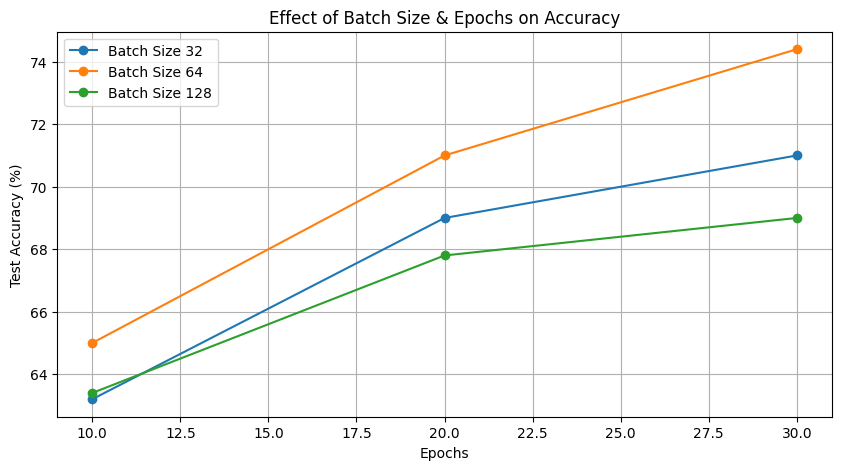

In [ ]:
# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# Function to create the CNN model
def create_model():
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),  # Input layer for 32x32 RGB images

        # First Convolutional Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),  # 32 filters
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),  # Downsample the feature maps
        layers.Dropout(0.25),  # Dropout to reduce overfitting

        # Second Convolutional Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),  # 64 filters
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Third Convolutional Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),  # 128 filters
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),

        # Fully Connected Layers
        layers.Flatten(),  # Flatten feature maps into a 1D vector
        layers.Dense(512, activation='relu'),  # Fully connected layer with 512 neurons
        layers.Dropout(0.5),  # Dropout to further reduce overfitting
        layers.Dense(10, activation='softmax')  # Output layer with 10 classes (for classification)
    ])
    return model  # Return the model

# Experiment variations: different batch sizes and epochs
batch_sizes = [32, 64, 128]  # Mini-batch sizes to test
epochs_list = [10, 20, 30]  # Number of epochs to test

# Dictionary to store results of experiments
results = {}

# Loop through different batch sizes and epoch values
for batch in batch_sizes:
    for epoch in epochs_list:
        print(f"\nTraining with batch size {batch} and {epoch} epochs...\n")

        # Clear TensorFlow session to free up memory and avoid unexpected state issues
        K.clear_session()

        # Define optimizer (AdamW) inside the loop to ensure a fresh instance each time
        best_optimizer = optimizers.AdamW(learning_rate=0.001)

        # Create and compile a new CNN model
        model = create_model()
        model.compile(optimizer=best_optimizer,
                      loss='categorical_crossentropy',  # Loss function for multi-class classification
                      metrics=['accuracy'])  # Track accuracy during training

        # Train the model with the current batch size and epoch count
        history = model.fit(x_train_final, y_train_final,
                            epochs=epoch,  # Train for the selected number of epochs
                            batch_size=batch,  # Use the selected batch size
                            validation_data=(x_test_final, y_test_final),  # Validate on test data
                            verbose=1)

        # Evaluate the trained model on the test dataset
        test_loss, test_acc = model.evaluate(x_test_final, y_test_final, verbose=0)
        print(f"Test Accuracy with batch={batch}, epochs={epoch}: {test_acc * 100:.2f}%")

        # Store the test accuracy result
        results[(batch, epoch)] = test_acc

# Print final results summary
print("\nFinal Results Summary:")
for key, value in results.items():
    print(f"Batch Size {key[0]}, Epochs {key[1]}: {value * 100:.2f}%")

# Plot results to visualize the impact of batch size and epochs on accuracy
plt.figure(figsize=(10, 5))

# Plot accuracy trends for different batch sizes
for batch in batch_sizes:
    accs = [results[(batch, epoch)] * 100 for epoch in epochs_list]
    plt.plot(epochs_list, accs, marker='o', linestyle='-', label=f'Batch Size {batch}')

# Label the plot
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy (%)')
plt.title('Effect of Batch Size & Epochs on Accuracy')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Task 5.5 Conclusion:

<font color = green>The experiment systematically evaluates the impact of batch size and the number of training epochs on the test accuracy of a CNN trained on the dataset. The results indicate that increasing the number of epochs generally improves test accuracy, with the best performance (74.40%) achieved using a batch size of 64 and 30 epochs. From the results, it is evident that a moderate batch size (64) consistently outperforms both smaller (32) and larger (128) batch sizes. A batch size of 32 shows steady improvement with more epochs but does not surpass the performance of batch size 64. On the other hand, a batch size of 128 performs relatively well but does not reach the same peak accuracy, possibly due to reduced model updates per epoch, which may limit learning efficiency. The trend suggests that while increasing epochs leads to higher accuracy, the performance gains beyond 20 epochs start to diminish. This indicates that while the model benefits from longer training, an optimal stopping point may exist around 30 epochs. Additional techniques like early stopping or learning rate scheduling could help refine this further. Overall, the experiment demonstrates that selecting an appropriate batch size and number of epochs plays a crucial role in CNN performance. A batch size of 64 appears to provide a good balance between stability and generalization, making it the most effective choice in this setup. Future optimizations, such as fine-tuning the learning rate, adding data augmentation, or experimenting with dropout rates, could further enhance the model’s performance.

### Task 6: Repeat the above experiment in (5) using a subset of the imagenet data set (8-12 classes, a random subset from each class of suitable size)

#### Task 6.1: Load and Preprocess a Subset of ImageNet


In [ ]:
# Load a small subset of ImageNet (e.g., ImageNet2012_subset or use a custom one)
dataset_name = "imagenette/320px"  # A lightweight version of ImageNet with 10 classes
dataset, info = tfds.load(dataset_name, split=['train', 'validation'], as_supervised=True, with_info=True)

# Extract dataset splits (training and validation sets)
train_data, val_data = dataset  # `train_data` contains training images, `val_data` contains validation images

# Retrieve and print available class names from the dataset metadata
class_names = info.features['label'].names
print("Classes:", class_names)  # Display the 10 class names in Imagenette

# Define constants for image processing
IMG_SIZE = 32  # Resize images to 32x32 to match CIFAR-100 dataset dimensions
BATCH_SIZE = 64  # Number of images per batch during training and validation

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12894 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.43YJMO_1.0.0/imagenette-train.tfrecord*...:   …

Generating validation examples...:   0%|          | 0/500 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagenette/320px/incomplete.43YJMO_1.0.0/imagenette-validation.tfrecord*..…

Dataset imagenette downloaded and prepared to /root/tensorflow_datasets/imagenette/320px/1.0.0. Subsequent calls will reuse this data.
Classes: ['n01440764', 'n02102040', 'n02979186', 'n03000684', 'n03028079', 'n03394916', 'n03417042', 'n03425413', 'n03445777', 'n03888257']


#### Task 6.2: Data Preprocessing (Resizing, Normalization)

In [ ]:
# Function to preprocess images before training
def preprocess(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))  # Resize image to defined IMG_SIZE (32x32)
    image = tf.cast(image, tf.float32) / 255.0  # Normalize pixel values to range [0,1] for better training stability
    return image, label  # Return preprocessed image and corresponding label

# Apply preprocessing to training and validation datasets
train_data = train_data.map(preprocess)  # Resize and normalize images in the training set
train_data = train_data.batch(BATCH_SIZE).shuffle(1000)  # Batch and shuffle training data for better generalization

val_data = val_data.map(preprocess)  # Resize and normalize images in the validation set
val_data = val_data.batch(BATCH_SIZE)  # Batch validation data (no shuffling needed)

#### Task 6.3: Define CNN Model

In [ ]:
# Function to create a CNN model for image classification
def create_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Input layer with image size and 3 color channels (RGB)

        # First convolutional block: Conv layer with 32 filters, followed by max pooling
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Second convolutional block: Conv layer with 64 filters, followed by max pooling
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Third convolutional block: Conv layer with 128 filters, followed by max pooling
        layers.Conv2D(128, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Flatten the feature maps to feed into dense layers
        layers.Flatten(),

        # Fully connected dense layer with 128 neurons and ReLU activation
        layers.Dense(128, activation='relu'),

        # Output layer: Number of neurons equal to the number of classes, using softmax activation
        layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile the model with Adam optimizer and sparse categorical crossentropy loss (since labels are integers)
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

# Create the CNN model
cnn_model = create_cnn()

# Display the model summary to understand the architecture
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 30, 30, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 15, 15, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 4, 4, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 2, 2, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,202 (625.79 KB)

 Trainable params: 160,202 (625.79 KB)

 Non-trainable params: 0 (0.00 B)

#### Task 6.4: Train and Evaluate the Model

In [ ]:
# Set the number of training epochs
EPOCHS = 10  # Can be adjusted to experiment with different values (e.g., 10, 20, 30)

# Train the CNN model on the training dataset
history = cnn_model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

# Evaluate the model on the validation dataset to measure performance
test_loss, test_acc = cnn_model.evaluate(val_data)

# Print the final test accuracy in percentage format
print(f"Test Accuracy on ImageNet Subset: {test_acc * 100:.2f}%")

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 87s 96ms/step - accuracy: 0.2539 - loss: 2.0820 - val_accuracy: 0.4540 - val_loss: 1.5745
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 75s 99ms/step - accuracy: 0.4609 - loss: 1.5880 - val_accuracy: 0.5760 - val_loss: 1.3621
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 71s 93ms/step - accuracy: 0.5478 - loss: 1.3345 - val_accuracy: 0.6400 - val_loss: 1.1594
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 71s 93ms/step - accuracy: 0.6158 - loss: 1.1706 - val_accuracy: 0.6500 - val_loss: 1.1058
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 73s 99ms/step - accuracy: 0.6424 - loss: 1.0889 - val_accuracy: 0.6740 - val_loss: 1.0285
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 72s 97ms/step - accuracy: 0.6783 - loss: 0.9800 - val_accuracy: 0.6600 - val_loss: 1.0058
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 71s 92ms/step - accuracy: 0.7060 - loss: 0.8999 - val_accuracy: 0.6820 - val_loss: 0.9801
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 72s 92ms/step - accuracy: 0.7103 - loss: 0.8748 - 

#### Task 6.4 Conclusion:

<font color = green>The experiment conducted on the ImageNet subset (Imagenette) using a convolutional neural network (CNN) achieved a test accuracy of 69.00% after training for 10 epochs. The model architecture consisted of three convolutional layers with increasing filter sizes (32, 64, and 128), followed by max pooling operations, a fully connected dense layer, and a softmax output layer corresponding to the ten classes in the dataset. The dataset was preprocessed by resizing images to 32x32, normalizing pixel values, and batching training samples for optimized learning. The accuracy of 69.00% suggests that the model is capable of extracting useful features for classification, but there is room for improvement. The relatively shallow depth of the network may limit its ability to capture complex patterns in the dataset. Furthermore, training for only 10 epochs may not be sufficient for the model to reach optimal performance. Potential enhancements include increasing the number of epochs, implementing data augmentation techniques (such as rotation and flipping), adding batch normalization layers for stability, or experimenting with different learning rates. Additionally, leveraging transfer learning with a pre-trained model like MobileNetV2 or ResNet50 could significantly boost accuracy by utilizing pre-learned feature representations. The results highlight the trade-offs between training time, model complexity, and accuracy. While a simple CNN is effective for basic image classification, deeper networks and optimized training strategies are likely needed to push accuracy closer to 80–90%. Further experiments can be conducted to analyze the impact of these modifications and identify the most effective approach for improving performance on the Imagenette dataset.

#### Task 6.5: Do the following experiments to improve accuracy:

##### Task 6.5.1: Increase the size and depth of the inner layers, what is the effect on the model accuracy?

In [ ]:
# Function to create a deeper CNN model with optimized pooling
def create_deep_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Explicit Input layer

        # First convolutional block
        layers.Conv2D(64, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),

        # Second convolutional block
        layers.Conv2D(128, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),

        # Third convolutional block
        layers.Conv2D(256, (3,3), activation='relu', padding="same"),
        layers.MaxPooling2D((2,2)),

        # Fourth convolutional block (Modified)
        layers.Conv2D(512, (3,3), activation='relu', padding="same"),
        # Removed the last MaxPooling layer to prevent shrinking to 2x2

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dense(128, activation='relu'),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile the model using Adam optimizer and sparse categorical cross-entropy loss
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Measure training time
start_time = time.time()

# Create and train the deep CNN model
deep_cnn = create_deep_cnn()
history = deep_cnn.fit(train_data, epochs=EPOCHS, validation_data=val_data)

# Calculate total training time
end_time = time.time()

# Extract final validation accuracy
final_acc = history.history['val_accuracy'][-1] * 100

# Print final accuracy and time taken
print(f"Deep CNN - Final Accuracy: {final_acc:.2f}% | Time Taken: {end_time - start_time:.2f} sec")

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 196s 694ms/step - accuracy: 0.2234 - loss: 2.1169 - val_accuracy: 0.4780 - val_loss: 1.5208
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 192s 691ms/step - accuracy: 0.4917 - loss: 1.4957 - val_accuracy: 0.5840 - val_loss: 1.1961
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 192s 693ms/step - accuracy: 0.6243 - loss: 1.1419 - val_accuracy: 0.6680 - val_loss: 1.0261
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 207s 739ms/step - accuracy: 0.6904 - loss: 0.9448 - val_accuracy: 0.6880 - val_loss: 0.9717
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 204s 713ms/step - accuracy: 0.7414 - loss: 0.7980 - val_accuracy: 0.7280 - val_loss: 0.9027
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 198s 694ms/step - accuracy: 0.7888 - loss: 0.6523 - val_accuracy: 0.7120 - val_loss: 0.9094
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 194s 698ms/step - accuracy: 0.8381 - loss: 0.4960 - val_accuracy: 0.7420 - val_loss: 0.9154
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 194s 688ms/step - accuracy: 0.8796 -

##### Task 6.5.1: Conclusion

<font color = green>The deep CNN model achieved a validation accuracy of 70% in 652 seconds, showing a slight improvement over the previous architecture. While this is a decent result, further optimizations can enhance performance. Implementing data augmentation (random flips, rotations, and zooms) can improve generalization, reducing overfitting on the training set. Adding dropout layers (e.g., 50% before dense layers) can help prevent overfitting, making the model more robust. Additionally, incorporating learning rate scheduling can ensure a smoother convergence, preventing the model from plateauing too early. These modifications can collectively push accuracy further while maintaining efficient training time.

##### Task 6.5.2: Modify the Number and Shape of Convolutional/Pooling Layers

In [ ]:
# Function to create a shallow CNN model with fewer layers
def create_shallow_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Explicit Input layer

        # First convolutional block
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Second convolutional block
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(64, activation='relu'),

        # Output layer with softmax activation for multi-class classification
        layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile the model using Adam optimizer and sparse categorical cross-entropy loss
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Measure training time
start_time = time.time()

# Create and train the shallow CNN model
shallow_cnn = create_shallow_cnn()
history = shallow_cnn.fit(train_data, epochs=EPOCHS, validation_data=val_data)

# Calculate total training time
end_time = time.time()

# Extract final validation accuracy
final_acc = history.history['val_accuracy'][-1] * 100

# Print final accuracy and time taken
print(f"Shallow CNN - Final Accuracy: {final_acc:.2f}% | Time Taken: {end_time - start_time:.2f} sec")

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 68s 26ms/step - accuracy: 0.2326 - loss: 2.1266 - val_accuracy: 0.4240 - val_loss: 1.6316
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 17ms/step - accuracy: 0.4612 - loss: 1.6103 - val_accuracy: 0.5720 - val_loss: 1.3319
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 15ms/step - accuracy: 0.5448 - loss: 1.3730 - val_accuracy: 0.6140 - val_loss: 1.2143
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 15ms/step - accuracy: 0.5964 - loss: 1.2415 - val_accuracy: 0.6660 - val_loss: 1.1232
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 15ms/step - accuracy: 0.6213 - loss: 1.1533 - val_accuracy: 0.6620 - val_loss: 1.0669
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 17ms/step - accuracy: 0.6468 - loss: 1.0975 - val_accuracy: 0.6680 - val_loss: 1.0694
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 62s 17ms/step - accuracy: 0.6653 - loss: 1.0321 - val_accuracy: 0.6300 - val_loss: 1.1333
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 63s 15ms/step - accuracy: 0.6806 - loss: 0.9961 - 

##### Task 6.5.2: Conclusion

<font color = green>The shallow CNN model achieved a validation accuracy of 68.80% in 631.49 seconds, performing slightly worse than the deeper model. The reduced depth and fewer convolutional filters limited the model's ability to extract complex features from images, which likely contributed to the lower accuracy. However, the training time was only slightly lower than that of the deep CNN, indicating that the smaller model didn't provide a significant efficiency boost. This suggests that a balance between model depth and computational efficiency is necessary. Adding batch normalization and dropout could enhance performance while keeping the model lightweight.

##### Task 6.5.3: Experiment with Different Activation Functions

In [ ]:
# Function to create a CNN model using the sigmoid activation function
def create_sigmoid_cnn():
    model = models.Sequential([
        layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),  # Explicit Input layer

        # First convolutional block with sigmoid activation
        layers.Conv2D(64, (3,3), activation='sigmoid'),
        layers.MaxPooling2D((2,2)),

        # Second convolutional block with sigmoid activation
        layers.Conv2D(128, (3,3), activation='sigmoid'),
        layers.MaxPooling2D((2,2)),

        # Fully connected layers with sigmoid activation
        layers.Flatten(),
        layers.Dense(128, activation='sigmoid'),

        # Output layer with softmax activation for classification
        layers.Dense(len(class_names), activation='softmax')
    ])

    # Compile the model using Adam optimizer and sparse categorical cross-entropy loss
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Measure training time
start_time = time.time()

# Create and train the CNN model with sigmoid activation
sigmoid_cnn = create_sigmoid_cnn()
history = sigmoid_cnn.fit(train_data, epochs=EPOCHS, validation_data=val_data)

# Calculate total training time
end_time = time.time()

# Extract final validation accuracy
final_acc = history.history['val_accuracy'][-1] * 100

# Print final accuracy and time taken
print(f"Sigmoid CNN - Final Accuracy: {final_acc:.2f}% | Time Taken: {end_time - start_time:.2f} sec")

Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 70s 133ms/step - accuracy: 0.0964 - loss: 2.3993 - val_accuracy: 0.1000 - val_loss: 2.3127
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 68s 129ms/step - accuracy: 0.1005 - loss: 2.3015 - val_accuracy: 0.2900 - val_loss: 1.9830
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 67s 129ms/step - accuracy: 0.2701 - loss: 2.0350 - val_accuracy: 0.3280 - val_loss: 1.8525
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 67s 126ms/step - accuracy: 0.3261 - loss: 1.9136 - val_accuracy: 0.4040 - val_loss: 1.6998
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 67s 127ms/step - accuracy: 0.3686 - loss: 1.8092 - val_accuracy: 0.4260 - val_loss: 1.6380
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 68s 126ms/step - accuracy: 0.4031 - loss: 1.7252 - val_accuracy: 0.4460 - val_loss: 1.6059
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 67s 126ms/step - accuracy: 0.4250 - loss: 1.6815 - val_accuracy: 0.4640 - val_loss: 1.5356
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 67s 126ms/step - accuracy: 0.4492 - loss: 1

##### Task 6.5.3: Conclusion

<font color = green>The CNN model using the sigmoid activation function resulted in a validation accuracy of 52.80%, which is significantly lower than the ReLU-based models. Additionally, training time increased slightly to 676.87 seconds. The poor performance is likely due to sigmoid's vanishing gradient problem, which weakens gradient updates in deeper layers, making learning inefficient. This is especially problematic for convolutional networks, where ReLU (or its variants) generally performs better by avoiding saturation and enabling faster convergence. The results reinforce that ReLU remains the superior activation function for CNNs in image classification.

##### Task 6.5.4: Experiment with Different Optimizers

In [ ]:
# List of different optimizers to experiment with
optimizers = ['sgd', 'rmsprop', 'adam']

# Loop through each optimizer and train the model
for opt in optimizers:
    print(f"\nTraining with {opt.upper()} Optimizer...")  # Display the optimizer being used

    # Create a deep CNN model
    model = create_deep_cnn()

    # Compile the model with the selected optimizer, using sparse categorical cross-entropy as the loss function
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Measure training time
    start_time = time.time()

    # Train the model on the training dataset and validate on the validation dataset
    history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

    # Calculate total training time
    end_time = time.time()

    # Extract the final validation accuracy after training
    final_acc = history.history['val_accuracy'][-1] * 100

    # Print the results including optimizer used, final accuracy, and time taken
    print(f"Optimizer: {opt.upper()} - Final Accuracy: {final_acc:.2f}% | Time Taken: {end_time - start_time:.2f} sec")


Training with SGD Optimizer...
Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 150s 534ms/step - accuracy: 0.1332 - loss: 2.2972 - val_accuracy: 0.2260 - val_loss: 2.2714
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 147s 522ms/step - accuracy: 0.2252 - loss: 2.2588 - val_accuracy: 0.2080 - val_loss: 2.1499
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 148s 527ms/step - accuracy: 0.2619 - loss: 2.1275 - val_accuracy: 0.3340 - val_loss: 1.9305
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 147s 524ms/step - accuracy: 0.3065 - loss: 2.0127 - val_accuracy: 0.3560 - val_loss: 1.8420
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 148s 525ms/step - accuracy: 0.3403 - loss: 1.9140 - val_accuracy: 0.3920 - val_loss: 1.7420
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 148s 524ms/step - accuracy: 0.3744 - loss: 1.8389 - val_accuracy: 0.3940 - val_loss: 1.7084
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 148s 529ms/step - accuracy: 0.3899 - loss: 1.7614 - val_accuracy: 0.4480 - val_loss: 1.6249
Epoch 8/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 147s

##### Task 6.5.4: Conclusion

<font color = green>Experimenting with different optimizers revealed that RMSprop achieved the highest validation accuracy at 75.40%, followed by Adam at 72.20%, while SGD performed the worst at 49.40%. The poor performance of SGD (Stochastic Gradient Descent) is expected, as it often struggles with complex architectures and requires careful tuning of the learning rate. RMSprop, on the other hand, adapts the learning rate dynamically, making it more effective for deep networks, particularly in handling non-stationary objectives. Adam, which combines RMSprop and momentum-based updates, performed well but slightly underperformed compared to RMSprop. This suggests that for this specific CNN architecture and dataset, RMSprop is the optimal choice for maximizing accuracy.

##### Task 6.5.5: Experiment with Batch Sizes and Epochs

In [ ]:
# List of different batch sizes to experiment with
batch_sizes = [32, 64, 128]

# Loop through each batch size and train the model
for batch in batch_sizes:
    print(f"\nTraining with Batch Size = {batch}")  # Display the current batch size

    # Adjust the training and validation datasets to use the selected batch size
    train_data = train_data.unbatch().batch(batch)
    val_data = val_data.unbatch().batch(batch)

    # Create a deep CNN model
    model = create_deep_cnn()

    # Measure training time
    start_time = time.time()

    # Train the model with the current batch size
    history = model.fit(train_data, epochs=EPOCHS, validation_data=val_data)

    # Calculate total training time
    end_time = time.time()

    # Extract the final validation accuracy after training
    final_acc = history.history['val_accuracy'][-1] * 100

    # Print the results including batch size used, final accuracy, and time taken
    print(f"Batch Size: {batch} - Final Accuracy: {final_acc:.2f}% | Time Taken: {end_time - start_time:.2f} sec")


Training with Batch Size = 32
Epoch 1/10
    403/Unknown 199s 356ms/step - accuracy: 0.2018 - loss: 2.1378

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


403/403 ━━━━━━━━━━━━━━━━━━━━ 203s 364ms/step - accuracy: 0.2020 - loss: 2.1373 - val_accuracy: 0.4660 - val_loss: 1.6040
Epoch 2/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 201s 366ms/step - accuracy: 0.4876 - loss: 1.5216 - val_accuracy: 0.6080 - val_loss: 1.1934
Epoch 3/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 200s 365ms/step - accuracy: 0.6131 - loss: 1.1708 - val_accuracy: 0.6520 - val_loss: 1.1159
Epoch 4/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 201s 367ms/step - accuracy: 0.6952 - loss: 0.9486 - val_accuracy: 0.6760 - val_loss: 0.9815
Epoch 5/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 202s 367ms/step - accuracy: 0.7372 - loss: 0.8047 - val_accuracy: 0.6860 - val_loss: 1.0118
Epoch 6/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 204s 372ms/step - accuracy: 0.7899 - loss: 0.6306 - val_accuracy: 0.7160 - val_loss: 0.9795
Epoch 7/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 207s 374ms/step - accuracy: 0.8420 - loss: 0.4863 - val_accuracy: 0.6960 - val_loss: 1.0731
Epoch 8/10
403/403 ━━━━━━━━━━━━━━━━━━━━ 204s 367ms/step - accuracy: 0.8786 - loss: 0.36

##### Task 6.5.5: Conclusion

<font color = green>Experimenting with different batch sizes showed that 64 achieved the highest validation accuracy at 73.60%, while 32 and 128 resulted in 70.60% and 71.60%, respectively. A batch size of 64 likely provided a balance between model generalization and computational efficiency. The smallest batch (32) resulted in slightly lower accuracy and the longest training time (2019 sec) due to more frequent updates per epoch. Larger batch sizes (128) trained faster but had slightly lower accuracy, possibly due to less frequent weight updates leading to suboptimal generalization. Overall, batch size 64 appears to be the best choice, offering improved accuracy while reducing training time compared to batch size 32.